In [51]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import integrate
import tensorflow as tf
from scipy.signal import argrelextrema

Hamiltonian for harmonic oscilator <br>
$H = \frac{p^2}{2m} + \frac{1}{2}kq^2$ <br>
$\dot{q} = \frac{p}{m}$<br>
$\dot{p} = kq$    dt = 0.02
    t_end = 50

$ freq = \frac{\sqrt{\frac{k}{m}}}{2\pi}$


In [52]:
dt = 0.02
t_end = 50

In [53]:
class Oscillator:
    def __init__(self,q,k,m,dt,t_end):
        self.q = q
        self.p = 0
        self.k = k
        self.m = m
        
    # Hamiltonian system
    def f(self,t,r):
        q, p = r
        k = self.k
        m = self.m
        
        q_dot = p/m
        p_dot = -k*q 
    
        return q_dot, p_dot
    
    def solve(self):
        traj = integrate.solve_ivp(self.f,(0,t_end),(self.q,self.p),max_step = dt, atol = 1, method = 'RK45')
        return np.array((traj.y[0],traj.y[1],traj.t))

In [54]:
def get_traj(freq_list):
    
    # IC's
    q0 = 1
    m = 1
    size = int(t_end/dt+1)
    osc_combine0 = np.zeros((size))
    osc_combine1 = np.zeros((size))
    for i in range(np.array(freq_list).shape[0]):
        k = m*(freq_list[i]*2*np.pi)**2
        osc = Oscillator(q0,k,m,dt,t_end)
        osc_combine0 += osc.solve()[0]
        osc_combine1 += osc.solve()[1]
            
    traj = np.reshape(np.array((osc_combine0,osc_combine1,osc.solve()[2])),(3,osc.solve().shape[1])) #(q,p,t)
    
    return traj

In [55]:
class LSTM_model():
    def __init__(self, n_M, state_size):
        self.n_M = n_M
        self.state_size = state_size
    
    def gen_data(self,traj,train_size):
        # Convert data to NN format
        self.traj = traj
        self.train_size = train_size
        train_count = 0
        train_in = np.zeros((2,train_size,self.n_M+1)) # q and p
        train_out  = np.zeros((2,train_size)) # q and p

        for i in range(train_size): # Loop through trajectory
            init_t = int(np.floor(np.random.uniform(0,t_end/dt+1-(self.n_M+2))))
            train_in[:,train_count,:] = traj[0:2,init_t:init_t+self.n_M+1] # n-n_m to n points (ie. current n and all memories)
            train_out[:,train_count] = traj[0:2,init_t+self.n_M+1] # n+1 point
            train_count += 1
            
        self.train_in = train_in
        self.train_out = train_out
        
    def build_model(self):
        inputs = tf.keras.Input((self.n_M+1,1))
        layer = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(self.state_size))(inputs)
        outputs = tf.keras.layers.Dense(1)(layer)
        model = tf.keras.Model(inputs,outputs)
        #model.summary(line_length = 200)
        self.model = model
        
    def train_model(self,batch_size,epochs):
        tf.random.set_seed(0)
        optimizer = tf.keras.optimizers.Adam(lr = .001)
        self.model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
        history  = self.model.fit(self.train_in[0,:,:].reshape(self.train_size,-1,1).astype('float32'),
                                  self.train_out[0,:].reshape(self.train_size,1).astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)
        optimizer = tf.keras.optimizers.Adam(lr = .0001)
        self.model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
        history  = self.model.fit(self.train_in[0,:,:].reshape(self.train_size,-1,1).astype('float32'),
                                  self.train_out[0,:].reshape(self.train_size,1).astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)
        optimizer = tf.keras.optimizers.Adam(lr = .00001)
        self.model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
        history  = self.model.fit(self.train_in[0,:,:].reshape(self.train_size,-1,1).astype('float32'),
                                  self.train_out[0,:].reshape(self.train_size,1).astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)
        
    def predict(self,length):
        S = np.zeros((1,length+2))
        S[0,0:self.n_M+1] = self.traj[0,0:self.n_M+1]
        t = self.traj[2,0:length+2]
        for i in range(length+3-(self.n_M+2)): # 0 to 20 by 0.02 in time
            S[0,i+self.n_M+1] = self.model.predict(np.reshape(S[0,i:i+self.n_M+1],(1,self.n_M+1,1)))
        
        self.ground_truth = np.array([traj[2,0:length+2],traj[0,0:length+2]])
        self.prediction = np.array([traj[2,0:length+2],S[0,:]])
        
    def get_pred(self):
        return self.ground_truth,self.prediction

In [56]:
def run_model(n_M,state_size,traj):
    test = LSTM_model(n_M,state_size)
    test.gen_data(traj,1000)
    test.build_model()
    test.train_model(5,10)
    test.predict(1000)
    gt, pred = test.get_pred()
    return gt, pred, test

In [57]:
def fast_fourier(traj):
    fourierTransform = np.fft.fft(traj)/len(traj)           # Normalize amplitude
    fourierTransform = fourierTransform[range(int(len(traj)/2))] # Exclude sampling frequency
    tpCount     = len(traj)
    values      = np.arange(int(tpCount/2))
    timePeriod  = tpCount/(1/.02)
    frequencies = values/timePeriod
    return frequencies, fourierTransform

In [58]:
n_M_list = np.array([10,30,50,70,90,120,150])
state_size_list = np.array([10,30,50,70,90,120,150])
traj_list = np.array([[0.05,0.15],[0.05,0.25],[0.05,0.35],[0.05,0.45],[0.05,0.55],[0.05,0.65]])

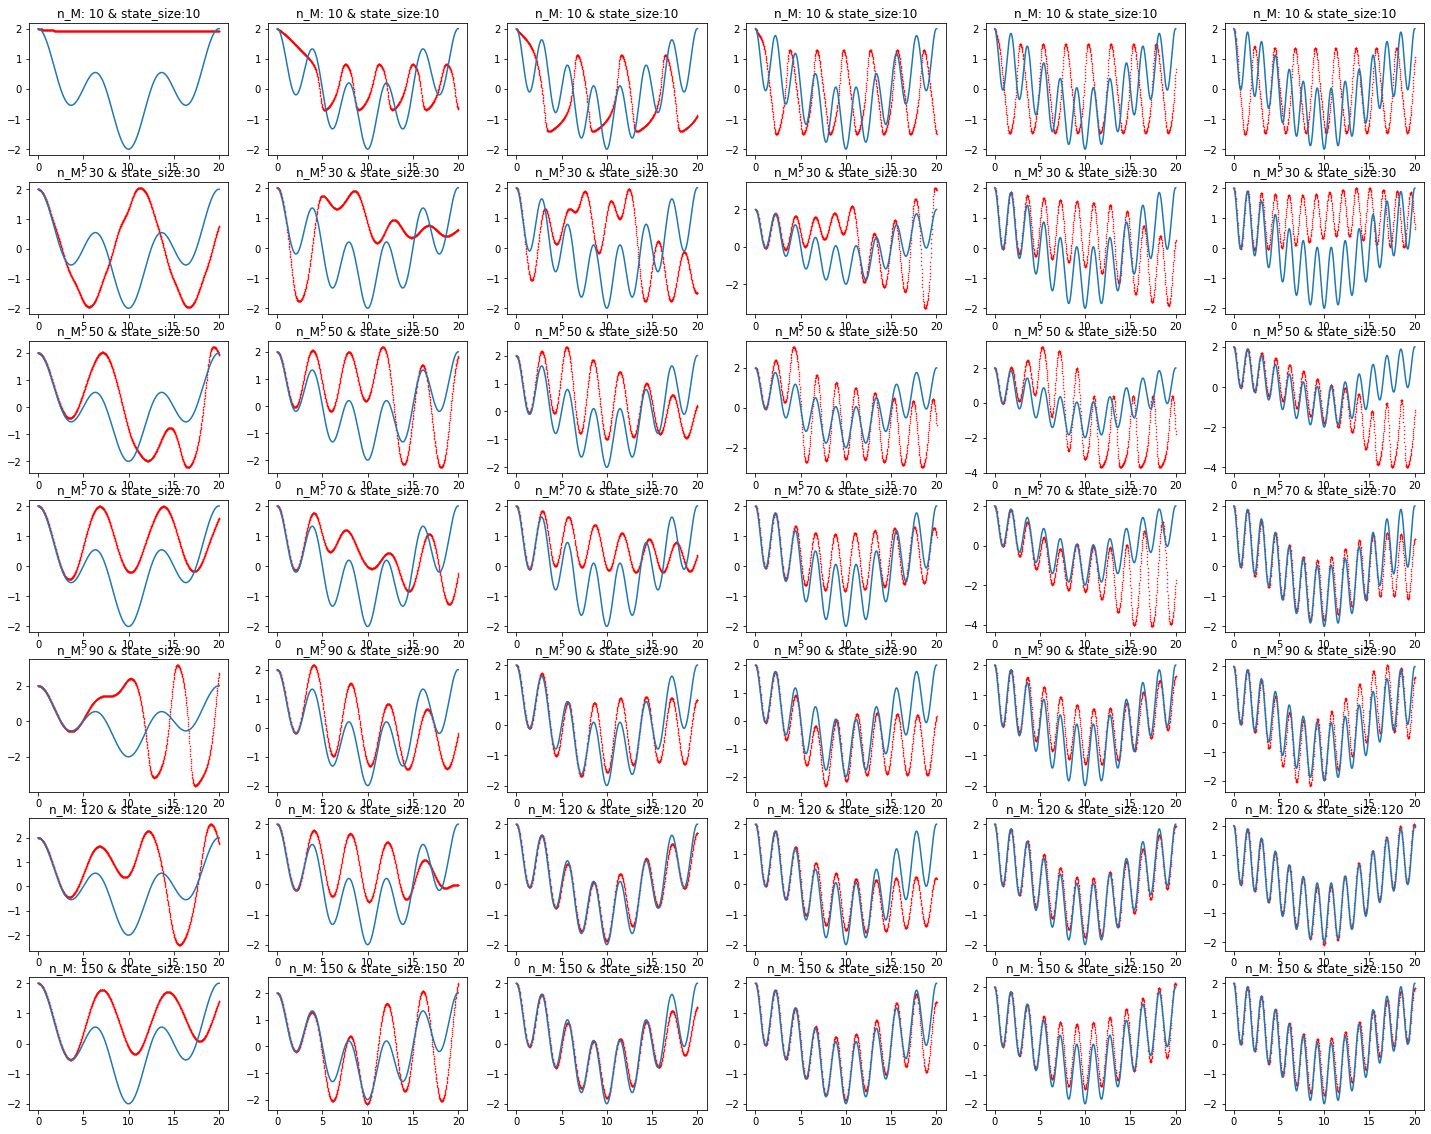

In [60]:
fig, ax = plt.subplots(n_M_list.shape[0],traj_list.shape[0],figsize=(25,20))
model_list = []
for i in range(n_M_list.shape[0]):
    for j in range(traj_list.shape[0]):
        n_M = n_M_list[i]
        state_size = state_size_list[i]
        traj = get_traj(traj_list[j])
        gt, pred, test = run_model(n_M,state_size,traj)
        model_list.append(test)
        # Plot q
        ax[i, j].set_title('n_M: '+str(n_M) +' & state_size:'+str(state_size))
        ax[i, j].plot(gt[0],gt[1])
        ax[i, j].scatter(pred[0],pred[1],c='r',s=.25)

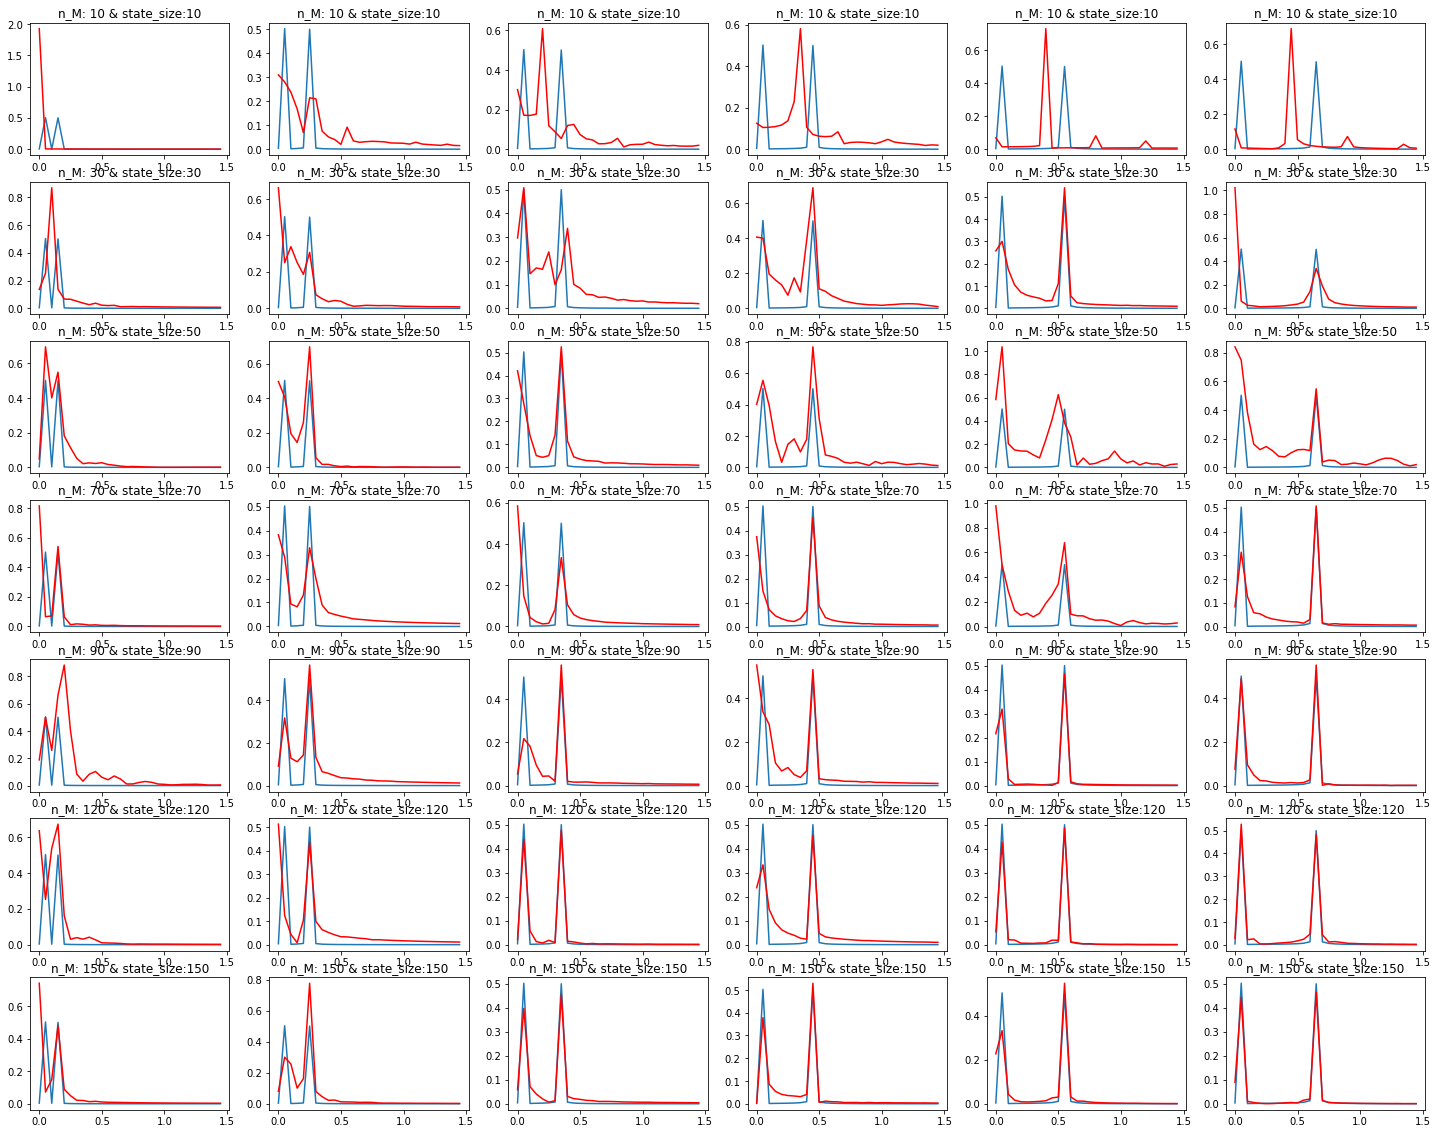

In [61]:
fig, ax = plt.subplots(n_M_list.shape[0],traj_list.shape[0],figsize=(25,20))
c = 0
for i in range(n_M_list.shape[0]):
    for j in range(traj_list.shape[0]):
        n_M = n_M_list[i]
        state_size = state_size_list[i]
        gt, pred = model_list[c].get_pred()
        # Plot fft
        fft_pred = fast_fourier(pred[1])
        fft_gt = fast_fourier(gt[1])
        ax[i, j].set_title('n_M: '+str(n_M) +' & state_size:'+str(state_size))
        ax[i, j].plot(fft_gt[0][0:30],abs(fft_gt[1][0:30]))
        ax[i, j].plot(fft_pred[0][0:30],abs(fft_pred[1][0:30]),c='r')
        c += 1

In [62]:
traj_list = np.array([[0.55],[0.55,0.45],[0.55,0.45,0.35],[0.55,0.45,0.35,0.25],[0.55,0.45,0.35,0.25,0.15],[0.55,0.45,0.35,0.25,0.15,0.05]])

C:\Users\Owner\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


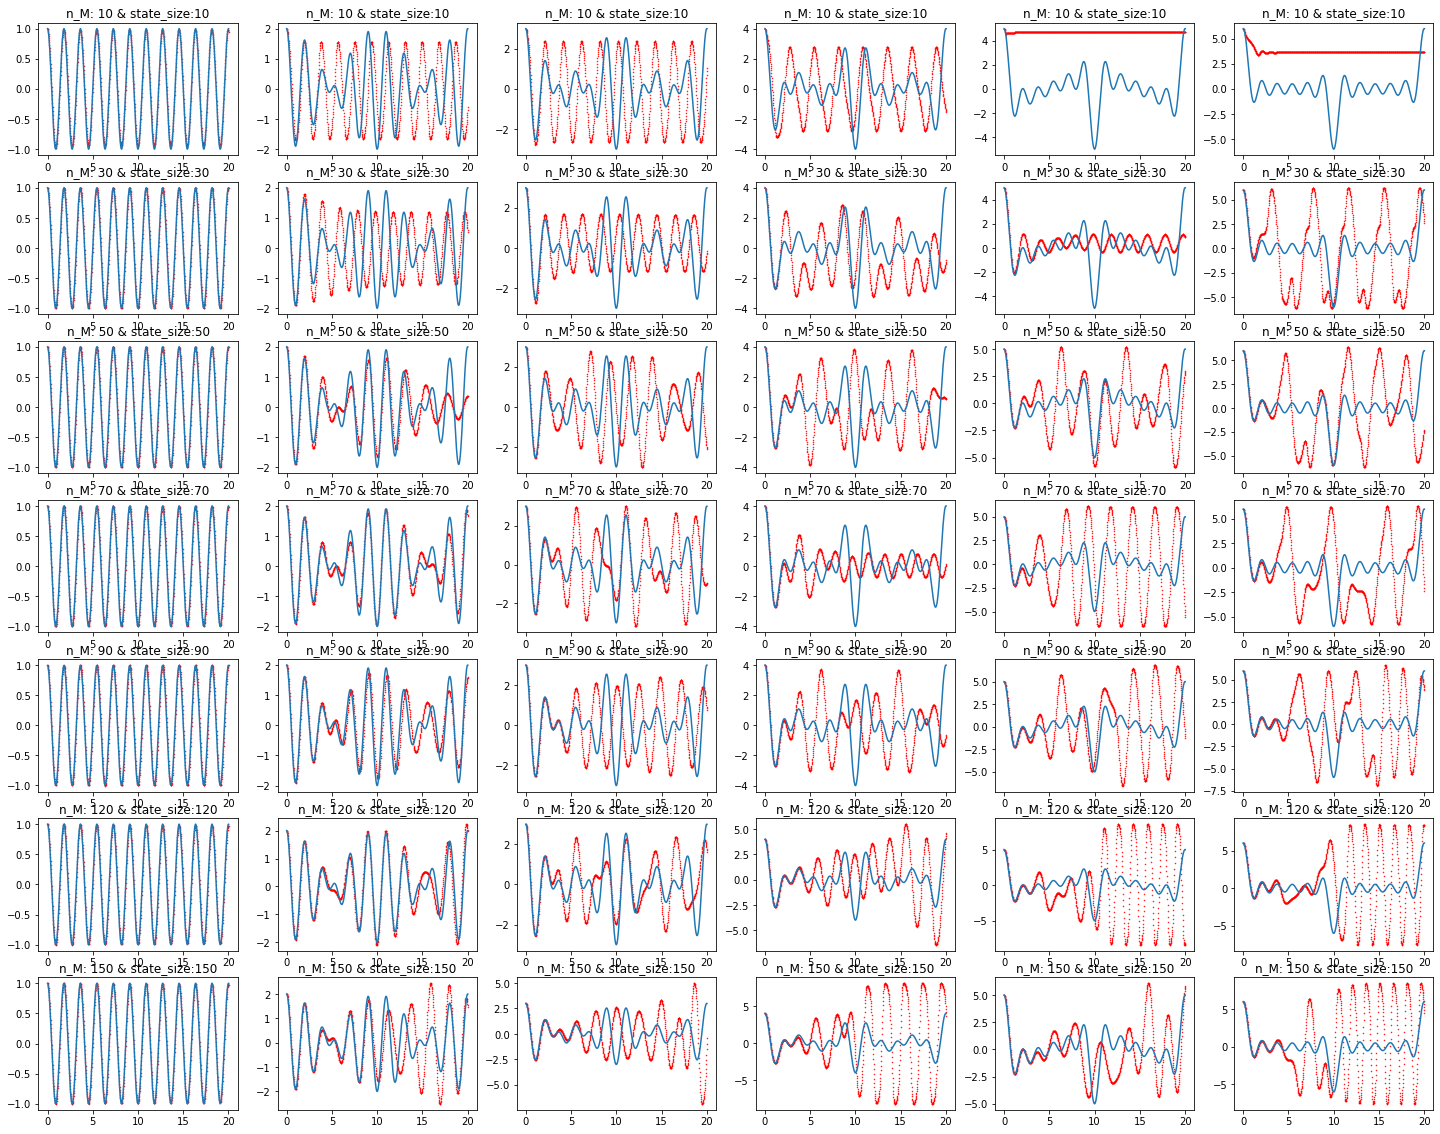

In [63]:
fig, ax = plt.subplots(n_M_list.shape[0],traj_list.shape[0],figsize=(25,20))
model_list_2 = []
for i in range(n_M_list.shape[0]):
    for j in range(traj_list.shape[0]):
        n_M = n_M_list[i]
        state_size = state_size_list[i]
        traj = get_traj(traj_list[j])
        gt, pred, test = run_model(n_M,state_size,traj)
        model_list_2.append(test)
        # Plot q
        ax[i, j].set_title('n_M: '+str(n_M) +' & state_size:'+str(state_size))
        ax[i, j].plot(gt[0],gt[1])
        ax[i, j].scatter(pred[0],pred[1],c='r',s=.25)

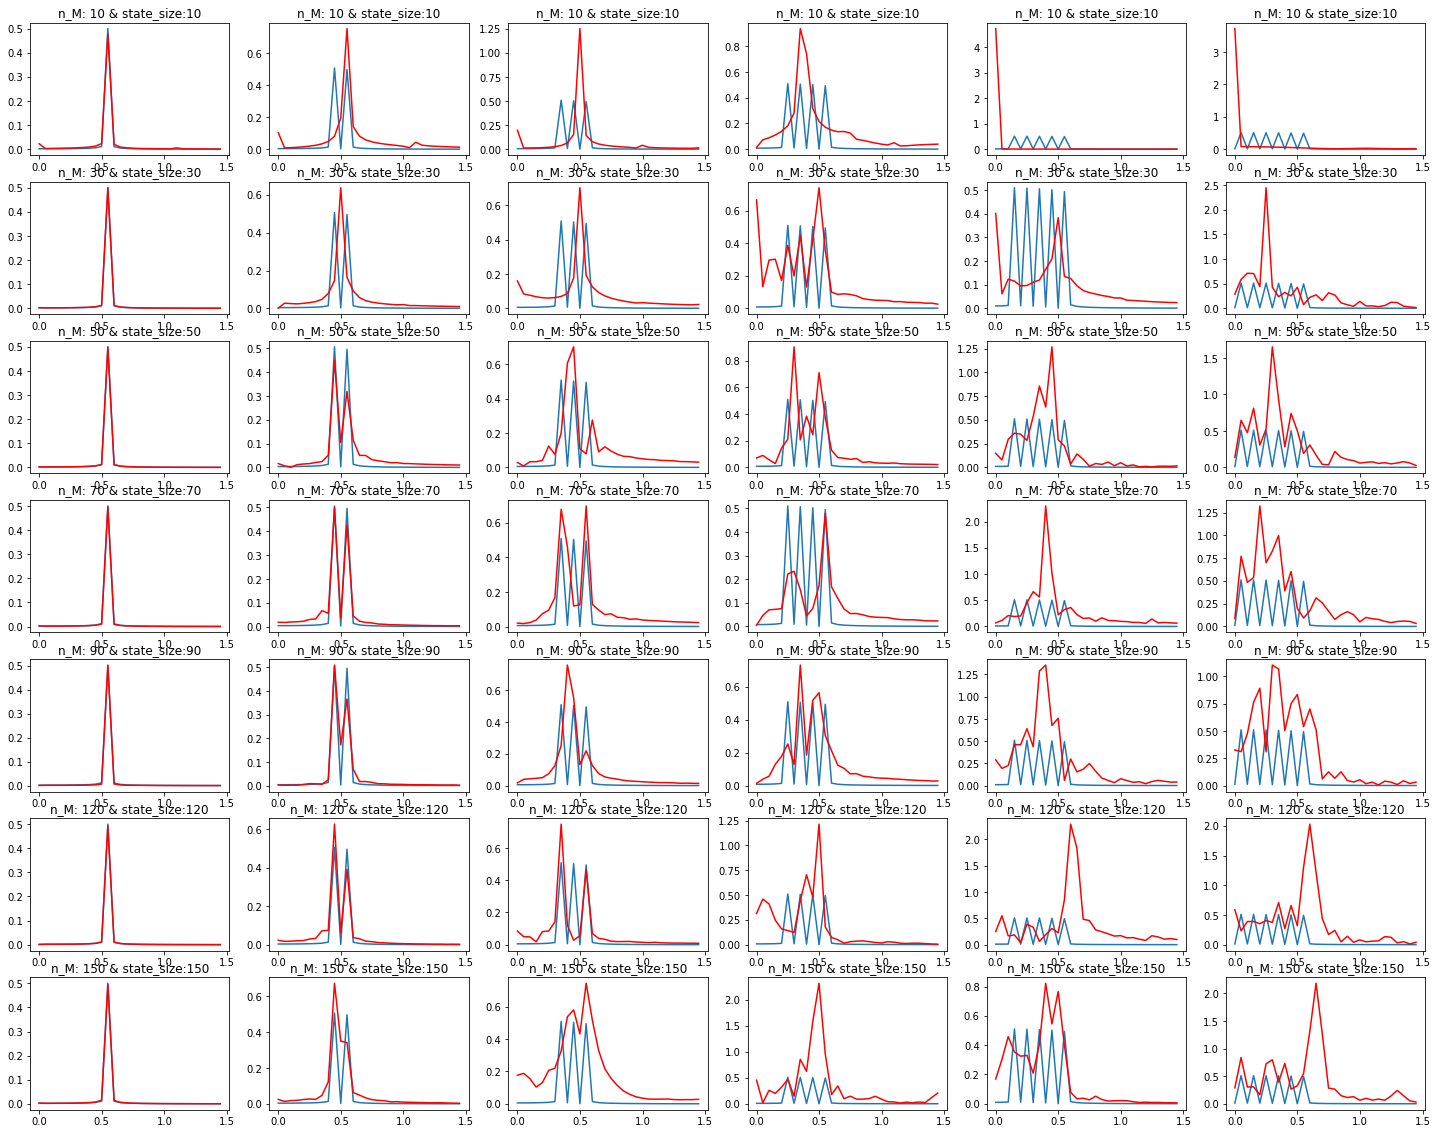

In [64]:
fig, ax = plt.subplots(n_M_list.shape[0],traj_list.shape[0],figsize=(25,20))
c = 0
for i in range(n_M_list.shape[0]):
    for j in range(traj_list.shape[0]):
        n_M = n_M_list[i]
        state_size = state_size_list[i]
        gt, pred = model_list_2[c].get_pred()
        # Plot fft
        fft_pred = fast_fourier(pred[1])
        fft_gt = fast_fourier(gt[1])
        ax[i, j].set_title('n_M: '+str(n_M) +' & state_size:'+str(state_size))
        ax[i, j].plot(fft_gt[0][0:30],abs(fft_gt[1][0:30]))
        ax[i, j].plot(fft_pred[0][0:30],abs(fft_pred[1][0:30]),c='r')
        c += 1